# Robinhood data  <a class="anchor" id="top"></a>

## TOC:
* [Robinhood platform wide data](#bullet1)
* [Data exploration and graphs](#bullet2)
* [Measuring stock performance using total Robinhood stock positions](#bullet3)
    - [Robinhood user growth](#sub-bullet3.1)
    - [Final solution](#sub-bullet3.2)
    - [Implementation of final solution](#sub-bullet3.3)
* [Data visualization](#bullet4)
    - [Merging Robintrack and TAQ data](#sub-bullet4.1)
    - [Graphs](#sub-bullet4.2)
* [ToDo](#bullet6)


The data from Robintrack is used as a proxy for Robinhood trader behaviour. It contains quite a lot of information which is not relevant for this research. As I am only looking at daily data, most hourly data points within this dataset are not used. Hence we will be filtered and adjust some of this data with the code in this file.


The Robintrack data set contains data points outside trade times.
This can be the case either
- during the weekend, or
- during the weekday outside trading hours
  Trading hours are weekdays from (Robinhood, 2022a):
  - 09:30 to 16:00 Eastern Daylight Time (ET)
  - 15:30 to 22:00 Central European Time (CET)
  - 13:30 to 20:00 Coordinated Universal Time (UTC)

The Robintrack data set is based on UTC times. I will be taking the last `users_holding` value of each day, to the closing day value.

In [5]:
import os
import numpy as np
import pandas as pd
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 20)

In [6]:
def loop_tickers(func):
    '''Decorator that loops all (ticker) files in the directory.'''
  
    def wrap(*args, **kwargs):
        if 'file_dir' in kwargs:
            for filename in os.listdir(filedir):
                csv_path = os.path.join(filedir, filename)
                kwargs['ticker'] = csv_path.split("\\")[-1].split(".")[0]
                # checking if it is a file
                if os.path.isfile(csv_path):
                    
                    message = f"""Now executing function {func.__name__} for [{filename}], variables:
                    - csv_path: [{csv_path}]
                    - kwargs: [{kwargs}])"""
                    print(message)

                    result = func(csv_path=csv_path, *args, **kwargs)
                    
        else:
            raise ValueError("Wrapper can not loop, as no file directory given. Please specify which folder needs to be looped by setting 'file_dir' variable.") 
        
        
        
        return result
    return wrap

In [3]:

def filters(df):
    #     -----------------     Filtering data and convert to daily     -----------------
    # Create dataframe and make sure timestamp is read as datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Create more info surrounding the date and time
    df['date'] = df['timestamp'].dt.date
    df['dayname'] = df['timestamp'].dt.day_name()

    # Remove all observations which are not weekdays
    df = df[~((df['dayname'] == "Saturday") | (df['dayname'] == "Sunday"))]
    
    # Keep only the last value of each day. This will portray the closing value of the users_holding variable for each day
    df = df.sort_values('timestamp').groupby('date').tail(1)

    #     -----------------     Creating new data     -----------------
    # Create column with numerical user difference
    df['change'] = df['users_holding'].diff()
    
    # Create column with percentual user difference
    df['pct_change'] = df['users_holding'].pct_change().round(4)
    
    # Dropping na values (this should only be the first column) and timestamp column
    df = df.dropna()
    df = df.drop(columns=['timestamp'])
    
    return df

In [7]:
save = False
@loop_tickers
def filter_data(csv_path, *args, **kwargs):
    """This function filters the unfiltered data to daily data"""
    df = pd.read_csv(csv_path)
    
    df = filters(df)
    
    # Remove any potential columns which are unnamed
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Adding ticker to df
    df['ticker'] = kwargs['ticker']
    # Setup save location by changing base_path from /unfiltered to /filtered
    base_path = os.path.dirname(kwargs['file_dir'])
    base_path = os.path.join(base_path, 'daily_data').replace('\\', '/')
    
    ticker = kwargs['ticker']
    save_path = os.path.join(base_path, f"{ticker}.csv").replace('\\', '/')

    # Save results
    df.to_csv(save_path, encoding='utf-8', index=False)

if save:
    filedir = r"E:/Users/Christiaan/Large_Files/Thesis/robintrack/popularity_export"
    filter_data(file_dir= filedir)


## Robinhood platform wide data <a class="anchor" id="bullet1"></a>

In order to gain insights into the Robinhood paltform as a whole, the data of all stocks is combined into 1 dataframe. To begin, the tickers are added to each file so the data can be traced to the right stock in the combined csv file.

In [5]:
# save = False

# filedir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data'

# # This loop adds the ticker name to the csv files
# for filename in os.listdir(filedir):
#     csv_path = os.path.join(filedir, filename)
#     ticker = filename.split(".")[0]
    
#     df = pd.read_csv(csv_path)
    
#     df['ticker'] = ticker
    
#     # Save only if save = True
#     if save:
#         df.to_csv(csv_path, encoding='utf-8', index=False)

The csv files (with the now newly added tickers) are now combined.

In [69]:
path = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data' # use your path

# Create a list in which all file paths are collected
all_files = glob.glob(os.path.join(path, "*.csv"))
all_files = [item.replace('\\', '/') for item in all_files]

# Create the dataframe in which all of these different files are added into one dataframe.
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# Change the 'date' column into a datetime object
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

# Remove any potential unnamed collumns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Saving the df
save = False
if save:
    df.to_csv(r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks_daily.csv', encoding='utf-8', index=False)

df

,users_holding,date,dayname,change,pct_change,ticker
0,587.0,2018-05-03,Thursday,-3.0,-0.0051,A
1,588.0,2018-05-04,Friday,1.0,0.0017,A
2,576.0,2018-05-07,Monday,-12.0,-0.0204,A
3,580.0,2018-05-08,Tuesday,4.0,0.0069,A
4,582.0,2018-05-09,Wednesday,2.0,0.0034,A
...,...,...,...,...,...,...
4089713,23.0,2020-08-07,Friday,0.0,0.0000,_PRN
4089714,24.0,2020-08-10,Monday,1.0,0.0435,_PRN
4089715,24.0,2020-08-11,Tuesday,0.0,0.0000,_PRN
4089716,24.0,2020-08-12,Wednesday,0.0,0.0000,_PRN


## Data exploration and graphs <a class="anchor" id="bullet2"></a>

**Stock availability**

In the graph below, the number of stocks available on the Robinhood platform are plotted.

In [11]:
# Read files which contains all info on all stocks.
csv_path = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks_daily.csv'
df = pd.read_csv(csv_path)
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

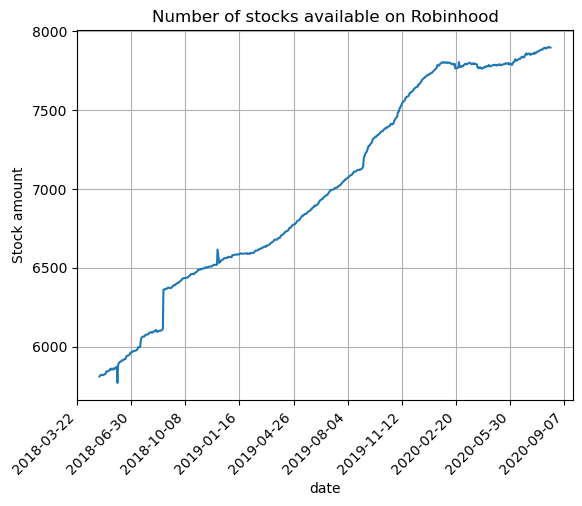

In [12]:
# Create the data in which the total stock offerings by Robinhood are calculated.
stock_choice = df.groupby('date', as_index=False).size()

# Plot the graph
fig, ax = plt.subplots()
ax.plot(stock_choice['date'], stock_choice['size'])

ax.set(xlabel='date', ylabel='Stock amount',
       title='Number of stocks available on Robinhood')

stepsize = 100
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize))

ax.grid()

plt.xticks(rotation=45, ha='right')
plt.show()

**Total stock positions Robinhood** <a class="anchor" id="graph1"></a>

To get an idea of the activity on the Robinhood platform, I take a look at the amounnt of stock positions held by Robinhood users. In the graph below, the number of stocks held by Robinhood investors are plotted based on the `total_users` dataframe created using the `all_stocks_daily.csv`. The total_users figure means that if RH has 1,000,000 users and they all own 3 different stocks, then the `total_users` would find 3,000,000 stocks. This is regardless if these users have 1 or 100 of these 3 different stocks.



In [13]:
# Create the data in which the total amount of user holdings are calculated.
total_users = df[['date', 'users_holding']].groupby('date', as_index=False).sum()

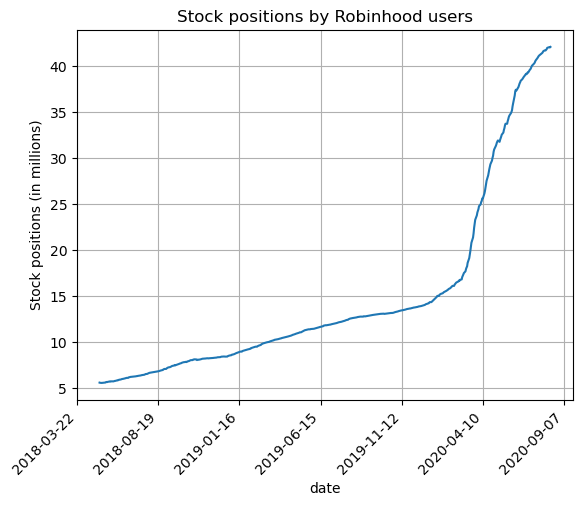

In [14]:
# Plot the graph
fig, ax = plt.subplots()
ax.plot(total_users['date'], total_users['users_holding']/1000000)

ax.set(xlabel='date', ylabel='Stock positions (in millions)',
       title='Stock positions by Robinhood users')
ax.grid()

stepsize = 150
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, stepsize))

plt.xticks(rotation=45, ha='right')
plt.show()

## Measuring stock performance using total Robinhood stock positions <a class="anchor" id="bullet3"></a>

With information about Robinhood being very scarse, the above graph is like a goldmine. It contains information on all the Robinhood users combined. I believe this information source can be used, in order to control for a number of variables which influence the Robintrack stock level data. The variables are:
- user growth on the Robinhood platform, and
- market movements.

<a class="anchor" id="table1"></a>

This information could be used by look at changes in the total stock positions. These changes would reflect both user growth and market movements and could be compared to stock level data to extract relative stock performance. 

| Date | Total stock positions | Change | Positions in 'stock x' | 'market' share |
| --- | --- | --- | --- | --- |
| 10-09-2018 | 12,500,000 | - | 320,000 | 2.56% |
| 11-09-2018 | 12,540,000 | +40,000 | 323,000 | 2.58% |
| 12-09-2018 | 12,515,000 | -25,000 | 323,000 | 2.58% |
| 13-09-2018 | 12,570,000 | +55,000 | 317,000 | 2.52% |

The `change in total stock positions` would be used in combination with the `'market' share`, to predict the `positions in 'stock x'` for the next period. The formula for the prediction would as followings

- $\text{Position stock x}_{t+1} = \text{Position stock x}_{t0} + (\text{Market Share stock x}_{t0} * \text{Change in total stock positions RH}_{t+1})$

| Date | Total stock positions | Change | Positions in 'stock x' | 'market' share | Predicted change | Predicted position 'stock x' |
| --- | --- | --- | --- | --- | --- | --- |
| 10-09-2018 | 12,500,000 | - | 320,000 | 2.56% | - | 320,000 |
| 11-09-2018 | 12,540,000 | +40,000 | 323,000 | 2.58% | +1024 | 321,024 |
| 12-09-2018 | 12,515,000 | -25,000 | 323,000 | 2.58% | -644 | 322,356 |
| 13-09-2018 | 12,570,000 | +55,000 | 317,000 | 2.52% | +1419 | 324,419 |


We can now compare the actual stock position versus the predicted stock position of 'stock x'. This comparison can be found in the `% diff` column. This column can serve as a proxy of stock trading activity on that day.

| Date | Positions in 'stock x' | Predicted position 'stock x' | % diff |
| --- | --- | --- | --- |
| 10-09-2018 | 320,000  | - | - |
| 11-09-2018 | 323,000 | 321,024 | <font color='green'>+0.61%</font> |
| 12-09-2018 | 323,000 | 322,356 | <font color='green'>+0.20%</font> |
| 13-09-2018 | 317,000 | 324,419 | <font color='red'>-2.34%</font> |

Please note that an example of the final version of this stock performance method can be found [here](#table2).


**Total unique shares per user vs total users on Robinhood**

In the total Robinhood stock position [graph](#graph1) graph the number of stocks held by Robinhood investors is plotted. With the steep rise in stock positions at the start of the first Covid lockdowns, it seems to be good indication of the amount of users on the Robinhood platform. However there is a problem with this figure. 

`Stock positions` in this case indicates the amount of unique stocks a user holds, regardless of the amount the user holds of each stock. This brings with it a problem, as both the amount of users and the average unique shares per user (AUSpU) can influence the value of `stock positions` and thus also the stock performance measure, as shown in the `% diff` column above. Although the graph above could indicate an increase in users, it could also just be that the existing users started to diversify and own a wider selection of stocks. An example of this would be the following

| Date | Stock positions | Robinhood users | avg unique shares per user (AUSpU) |
| --- | --- | --- | --- |
| 2017 | 1,000,000 | 100,000 | 10 |
| 2018 | 2,000,000 | 100,000 | 20 |
| 2019 | 3,000,000 | 100,000 | 30 |
| 2020 | 4,000,000 | 100,000 | 40 |

In this example the user amount did not change, only the average unique shares per user did. This example illustrates the problem of measuring total by `stock positions`

In the real world I expect both the user amount and the AUSpU to change:

| Date | Stock positions | Robinhood users | avg unique shares per user (AUSpU) |
| --- | --- | --- | --- |
| 2017 | 1,000,000 | 100,000 | 10 |
| 2018 | 2,000,000 | 150,000 | 13.33 |
| 2019 | 3,000,000 | 200,000 | 15 |
| 2020 | 4,000,000 | 250,000 | 16 |

### Robinhood user growth <a class="anchor" id="sub-bullet3.1"></a>

The problem above needs to be tackle, as otherwise the performance measure using the `change in total stock positions` in combination with the `'market' share` would be influenced not only by changes in the Robinhood user amount and market movements but also by `average unique shares per user (AUSpU)`.

In order to find the `AUSpU`, the total amount of Robinhood users are needed. To estimate the amount of Robinhood users, I make use of their SEC filings to extract `Monthly Active Users (MAU)` and `Net Cumulative Funded Accounts`. 

I will be mainly focussing on the Net Cumulative Funded Accounts, as these account contain a balance with which trades can be made. Robinhoods definition of Net Cumulative Funded Accounts is: "*Net Cumulative Funded Accounts. We define Net Cumulative Funded Accounts as the total of Net Funded Accounts from inception to a stated date or period end. “Net Funded Accounts” is the total number of Funded Accounts for a stated period, excluding “churned users” and including “resurrected users” as of the end of that period. A “Funded Account” is a Robinhood account into which the account user makes an initial deposit or money transfer, of any amount, during the relevant period, 25 which account is designed to provide a customer with access to any and all of the products offered on our platform. Users are considered “churned” if their accounts were previously Funded Accounts and their account balance (which is measured as the fair value of assets in the user’s account less the amount due from the user) drops to or below zero dollars (which negative balances typically result from Fraudulent Deposit Transactions and, less often, from margin loans) for 45 consecutive calendar days. Users are considered “resurrected” if they were considered churned users during and as of the end of the immediately preceding period, and had their account balance increase above zero (and are not considered churned users) in the current period. For more information about Fraudulent Deposit Transactions, see “Management’s Discussion and Analysis of Financial Condition and Results of Operations—Key Components of our Results of Operations—Operating Expenses—Operations.*"

The picture below shows Robinhood's `Net Cumulative Funded Accounts` growth over the years [(source)](https://www.sec.gov/Archives/edgar/data/1783879/000162828021013318/robinhoods-1.htm).

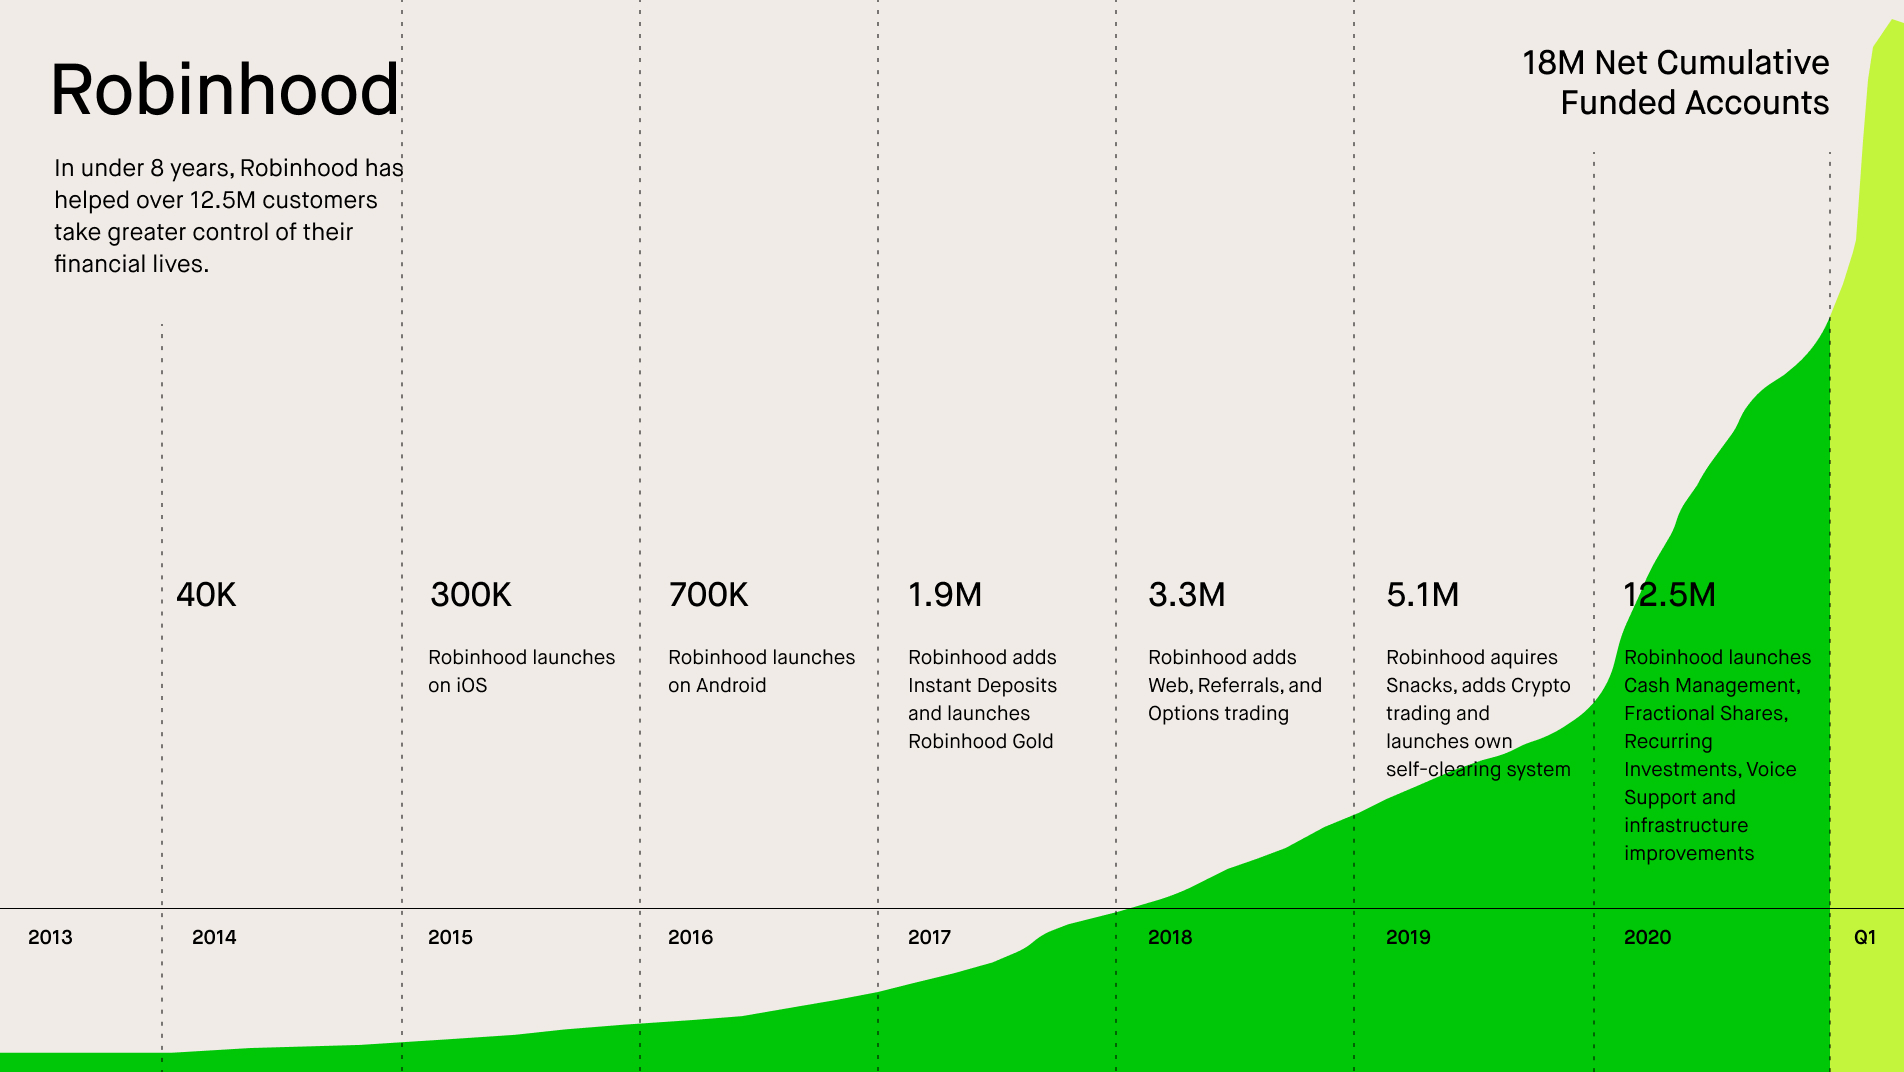

I recreate this graph using the data from the Robinhood SEC filings (using Form S-1, quarterly and annual reports). The values in red are values which are missing and have been interpolated.

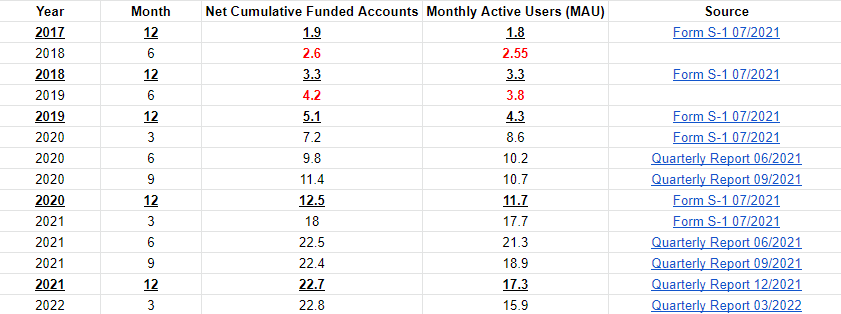

**Robinhood user growth estimation**

Using the data above, I interpolate the user growth for each day. This is done with the code below.

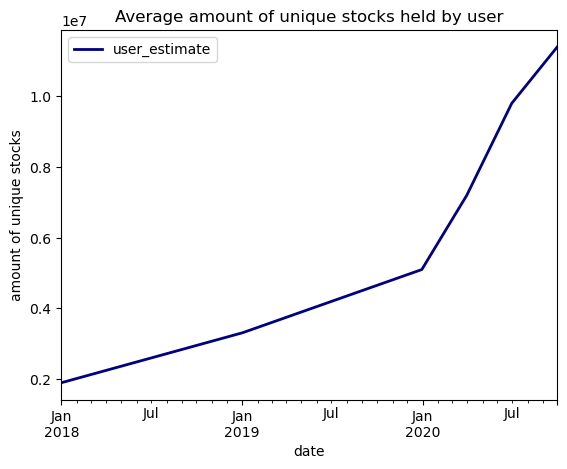

In [15]:
# Create an empty dataframe
user_prediction_df = pd.DataFrame()

# Create a date range relevant for interpolation.
user_prediction_df = user_prediction_df.reindex(pd.date_range("2018-01-01", "2020-9-30"), fill_value="NaN")

# Create and fill user_estimate column with nans
user_prediction_df['user_estimate'] = np.nan

# Put in values found from Robinhood filings (see above)
user_prediction_df.loc['2018-01-01'] = 1900000
user_prediction_df.loc['2018-06-30'] = 2600000
user_prediction_df.loc['2018-12-31'] = 3300000
user_prediction_df.loc['2019-06-30'] = 4200000
user_prediction_df.loc['2019-12-31'] = 5100000
user_prediction_df.loc['2020-03-31'] = 7200000
user_prediction_df.loc['2020-06-30'] = 9800000
user_prediction_df.loc['2020-09-30'] = 11400000

# Delete weekends from timeframe 
""" !!!
Weekends are deleted in order to not get a user bump on monday, but rather smooth user out over the week!
Although this assumes no new users join on the weekend, I believe this to be the best (neutral) approach as no further 
information is available on when Robinhood's peak hours are in terms of attracting new customers.
""" 
user_prediction_df = user_prediction_df[user_prediction_df.index.dayofweek < 5]

# Use pandas linear interpolation to fill in missing values
user_prediction_df = user_prediction_df['user_estimate'].interpolate(method='linear').round(0)

# Convert the index to a column 
user_prediction_df = user_prediction_df.reset_index(level=0)
user_prediction_df = user_prediction_df.rename(columns={"index": "date"})

# Plot results
ax = user_prediction_df.plot(x="date", y=["user_estimate"], lw=2, colormap='jet', markersize=10, title='Average amount of unique stocks held by user')
ax.set(xlabel="date", ylabel="amount of unique stocks")
plt.show()

**Average unique shares per user (AUSpU)**

Now we have a user estimate for each period, I will merge this data with the `total_users` data to find out what the AUSpU per account is.

In [16]:
# --------------------- Create acc_holdings_df ---------------------

# Putting total_users in new dataframe to preserve original
acc_holdings_df = total_users

# Merge user prediction dataframe with total_users dataframe
acc_holdings_df = acc_holdings_df.merge(user_prediction_df, how='left', left_on='date', right_on='date')

# Calculate average different stocks per account
acc_holdings_df['AUSpU'] = acc_holdings_df['users_holding'] / acc_holdings_df['user_estimate']

# Rename column
acc_holdings_df.rename(columns={'users_holding': 'RHtotal_holdings'}, inplace=True)

# --------------------- This part is relevant for later ---------------------
# Create column which tracks change in total share holdings
acc_holdings_df['RHtotal_holdings_change'] = acc_holdings_df['RHtotal_holdings'].diff()

# Reorder the columns
acc_holdings_df = acc_holdings_df[['date', 'RHtotal_holdings', 'RHtotal_holdings_change', 'user_estimate', 'AUSpU']]

acc_holdings_df.head(5)

,date,RHtotal_holdings,RHtotal_holdings_change,user_estimate,AUSpU
0,2018-05-03,5605203.0,NaN,2373846.0,2.361233
1,2018-05-04,5587108.0,-18095.0,2379231.0,2.348283
2,2018-05-07,5572033.0,-15075.0,2384615.0,2.336659
3,2018-05-08,5579299.0,7266.0,2390000.0,2.334435
4,2018-05-09,5581690.0,2391.0,2395385.0,2.330185


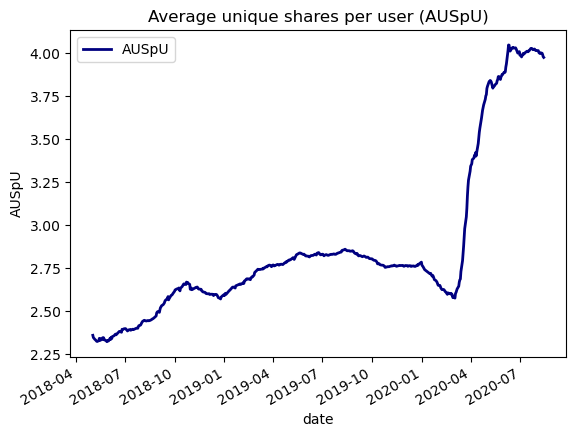

In [17]:
# Plot results
ax = acc_holdings_df.plot(x="date", y=["AUSpU"], lw=2, colormap='jet', markersize=10, title='Average unique shares per user (AUSpU)')
ax.set(xlabel="date", ylabel="AUSpU")
plt.show()


### Final solution <a class="anchor" id="sub-bullet3.2"></a>

<a class="anchor" id="table2"></a>

The graph shows that the AUSpU increased drastically over the time period. The AUSpU for each period can now be used to correct the change in total stock positions. Dividing the total stock positions by the AUSpU will result in the total change in stock positions to reflect changes in users and in the market, rather than changes in the AUSpU:

- $\text{Change in total users and/or market changes}_{t+1} = \frac{\text{Change in total stock positions RH}_{t+1}}{\text{AUSpU}_{t+0}}$

<br>

*Final prediction formula*<br>
In practise the AUSpU can be used in the previously mentioned prediction formula, giving us our **final prediction formula**:

- $\text{Expected position stock x}_{t+1} = \text{Position stock x}_{t0} + \text{Market Share stock x}_{t0} * \frac{\text{Change in total stock positions RH}_{t+1}}{\text{AUSpU}_{t+0}}$

 
Lastly, the stock's actual performance will be measured by comparing the expected stock position with the actual stock position. Using the expected stock position, the stocks relative performance can be measure. 
<font color='orange'><b>This relative performance is a **proxy for trading activity of the Robinhood traders**.</b></font> The following formula is used to find the performance of stock x:

- $\text{Performance stock x}_{t+1} = \frac{\text{Position stock x}_{t+1}}{\text{Position stock x}_{t+1} - \text{Expected position stock x}_{t+1}}$

To illustrate this with a similar example as [above](#table1):


| Date | Total stock positions | Change | Positions in 'stock x' | 'market' share | AUSpU | Predicted change (new) | Predicted position 'stock x' (new) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 10-09-2018 | 12,500,000 | - | 320,000 | 2.56% | 2 | - | - |
| 11-09-2018 | 12,540,000 | +40,000 | 323,000 | 2.58% | 3 | +512 | 320,512 |
| 12-09-2018 | 12,515,000 | -25,000 | 323,000 | 2.58% | 4 | -215 | 322,785 |
| 13-09-2018 | 12,570,000 | +55,000 | 317,000 | 2.52% | 5 | +355 | 323,355 |


We can now compare the actual stock position versus the predicted stock position of 'stock x'. This comparison can be found in the `% diff` column. This column can serve as a proxy of stock trading activity on that day.

| Date | AUSpU | Positions in 'stock x' | Predicted position 'stock x' (new) | % diff (new) | Predicted position 'stock x' (old) | % diff (old) |
| --- | --- | --- | --- | --- | --- | --- |
| 10-09-2018 | 2 | 320,000  | - | - | - | - |
| 11-09-2018 | 3 | 323,000 | 320,512 | <font color='green'>+0.77%</font> | 321,024 | <font color='green'>0.61%</font> |
| 12-09-2018 | 4 | 323,000 | 322,785 | <font color='green'>+0.07%</font> | 322,356 | <font color='green'>0.2%</font> |
| 13-09-2018 | 5 | 317,000 | 323,355 | <font color='red'>-2.00%</font> | 324,419 | <font color='red'>-2.34%</font> |



### Implementation of final solution <a class="anchor" id="sub-bullet3.3"></a>

Different versions of the formula will be used, in order to test the diferent measurements later on.

**Main performance measurement method** `df['expected_position_1']`:

- $\text{Expected position stock x}_{t+1} = \text{Position stock x}_{t0} + \text{Market Share stock x}_{t0} * \frac{\text{Change in total stock positions RH}_{t+1}}{\text{AUSpU}_{t+0}}$


**Second measurement method** `df['expected_position_2']`:

- $\text{Position stock x}_{t+1} = \text{Position stock x}_{t0} + (\text{Market Share stock x}_{t0} * \text{Change in total stock positions RH}_{t+1})$

**Expected stock position to stock_performance** `df['performance_x']`:
Using the expected stock position, the stocks relative performance can be measure. This reletive performance is a proxy for trading activity of the Robinhood traders. The following formula is used to find the performance of stock x:
- $\text{Performance stock x}_{t+1} = \frac{\text{Position stock x}_{t+1} - \text{Expected position stock x}_{t+1}}{\text{Expected position stock x}_{t+1}}$

In [27]:
"""This code will fill in the expected stock position prediction function

The variables can be found in the following columns:
'Position stock x (t=0)' = df['user_estimate']
'Market share stock x (t=0)' = df['market_share']
'Change in total stock positions RH (t+1)' = df['RHtotal_holdings_change']
'AUSpU (t=0)' = df['AUSpU']
"""

def calc_performance(df):
    # Make sure date column is in datetime format
    df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

    # Merge the dataframe with the acc_holdings_df (the df containing RH general info)
    df = acc_holdings_df.merge(df, how='left', left_on='date', right_on='date')

    # Drop the 'timestamp' column and remove any unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Calculate: Market share
    df['market_share'] = df['users_holding']/df['RHtotal_holdings']

    # Calculate expected stock position using the main version of the formula
    df['expected_position_1'] = df['users_holding'].shift(1) + (df['market_share'].shift(1) * (df['RHtotal_holdings_change'] / df['AUSpU'].shift(1))).round(0)
    
    # Calculate expected stock position using the main version of the formula
    df['expected_position_2'] = df['users_holding'].shift(1) + (df['market_share'].shift(1) * df['RHtotal_holdings_change']).round(0)
   
    
    # Calculate stock performance for all prediction methods
    df['performance_1'] = (df['users_holding'] - df['expected_position_1']) / df['expected_position_1']
    df['performance_2'] = (df['users_holding'] - df['expected_position_1']) / df['expected_position_1']

    
    # Change order of the columns
    df = df[['date', 
             'dayname', 
             'ticker', 
             'RHtotal_holdings', 
             'RHtotal_holdings_change', 
             'user_estimate', 
             'AUSpU', 
             'users_holding', 
             'change', 
             'pct_change', 
             'market_share', 
             'expected_position_1', 
             'performance_1',
             'expected_position_2', 
             'performance_2']]

    return df



In [28]:
save = True


filedir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_data'
ticker_list = ['TLRY','TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'LULU', 'BAC', 'GME']

if save:
    # This loop adds the ticker name to the csv files
    for filename in os.listdir(filedir):
        csv_path = os.path.join(filedir, filename)
        ticker = filename.split(".")[0]

        # Check if stock is in ticker_list, if not skip dataframe operations
        if ticker in ticker_list:
            # Read csv
            df = pd.read_csv(csv_path)

            # Calculate performance
            df = calc_performance(df)

            # Setup save location by changing base_path from /unfiltered to /filtered
            base_path = os.path.dirname(filedir)
            base_path = os.path.join(base_path, 'daily_25').replace('\\', '/')
            save_path = os.path.join(base_path, f"{ticker}.csv").replace('\\', '/')

            # Save results
            df.to_csv(save_path, encoding='utf-8', index=False)
            
        


## Data visualization <a class="anchor" id="bullet4"></a>

### Merging Robintrack and TAQ data <a class="anchor" id="sub-bullet4.1"></a>

While merging the the datasets, I discover a problem with the Robintrack dataset. The TAQ dataset seems to be missing obervations for quite a few days. When Googling, I find out that these are holidays on the exchanges [(source)](https://kfe.ee/doc/Holiday_Calendar_2019_By_Date.pdf). This means that no trading takes place on these days. Robinhood does have data for these points. Total users changes do seem to be minimal however, indicating the the Robinhood user changes seem to be small corrections.

To solve this problem I drop the relevant observation days in the Robinhood dataset.
These dates are:

| 2018 | 2019 | 2020 |
| --- | --- | --- |
| - | 01/01/2019 | 01/01/2020 |
| - | 21/01/2019 | 20/01/2020 |
| - | 18/02/2019 | 17/02/2020 |
| 28/05/2018 | 19/04/2019 | 10/04/2020 |
| 04/07/2018 | 27/05/2019 | 25/05/2020 |
| 03/09/2018 | 04/07/2019 | 03/07/2020 |
| 22/11/2018 | 02/09/2019 | - |
| 05/12/2018 | 28/11/2019 | - |
| 25/12/2018 | 25/12/2019 | - |




In [29]:
# Merge these 2 folder's files into 1
robintrack_dir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\daily_25'
taq_dir = r'E:\Users\Christiaan\Large_Files\Thesis\taq\filtered'

# Save dir
save_dir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack_taq'

# Ticker list
ticker_list = ['TLRY','TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'LULU', 'BAC', 'GME']
# ticker_list = ['TSLA']
# This loop adds the ticker name to the csv files
for filename in os.listdir(robintrack_dir):
    # Create path for both files
    robintrack_path = os.path.join(robintrack_dir, filename)
    taq_path = os.path.join(taq_dir, filename)

    
    ticker = filename.split(".")[0]
    # Check if stock is in ticker_list, if not skip dataframe operations
    if ticker in ticker_list:
        # Read csv
        robintrack_df = pd.read_csv(robintrack_path)
        taq_df = pd.read_csv(taq_path)
        
        # Removing unnamed columns
        taq_df = taq_df.loc[:, ~taq_df.columns.str.contains('^Unnamed')]

        # Rename taq columns to contain [taq]
        taq_df.columns = ['[taq]' + str(col) for col in taq_df.columns]
        
        # Merge dataframes
        merged_df = robintrack_df.merge(taq_df, how='left', left_on='date', right_on='[taq]date')
        merged_df = merged_df.drop(columns=['[taq]date'])
        
        # Dropping NA values (see explanation regarding holidays above)
        merged_df.dropna(axis=0, inplace=True)
        
        # Setting date to datetime object
        merged_df['date'] = pd.to_datetime(merged_df['date'].astype(str), format='%Y-%m-%d')

        # Setup save location
        save_path = os.path.join(save_dir, f"{ticker}.csv").replace('\\', '/')
        print(save_path)
        
        # Save results
        merged_df.to_csv(save_path, encoding='utf-8', index=False)
        


E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/AAPL.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/AMD.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/AMZN.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/ATVI.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/BA.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/BABA.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/BAC.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/DIS.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/F.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/GE.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/GME.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/IQ.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/LULU.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/MSFT.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/MU.csv
E:/Users/Christiaan/Large_Files/Thesis/robintrack_taq/NFLX.csv
E:/User

### Graphs <a class="anchor" id="sub-bullet4.2"></a>

In [202]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#000000"

    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
    ax2.plot(df[x], df[y2], label=y2, color=colour_3, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    ax1.plot(df[x], df[y1].rolling(5).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel(y2, color=colour_3, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()


In [203]:
filedir = r'E:\Users\Christiaan\Large_Files\Thesis\robintrack_taq'

def plot_ticker(ticker_list, x='date', y1='performance_1', y2='[taq]price'):
    for filename in os.listdir(filedir):
        csv_path = os.path.join(filedir, filename)
        ticker = filename.split(".")[0]

        # Check if stock is in ticker_list, if not skip dataframe operations
        if ticker in ticker_list:
            # Read csv
            df = pd.read_csv(csv_path)
            
            # Make sure it is datetime
            df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

            # Plot results
            plot_graph(df, ticker, x, y1, y2)


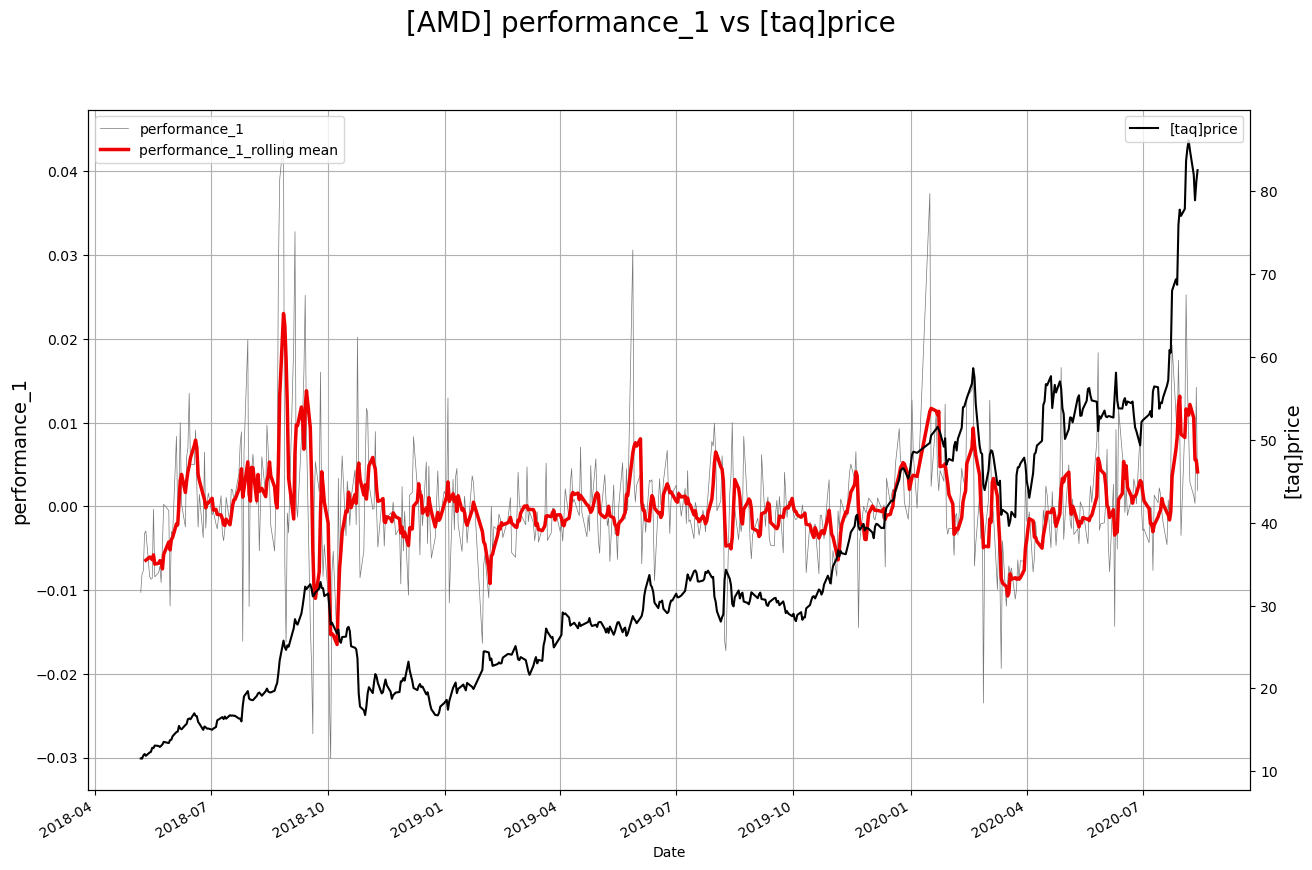

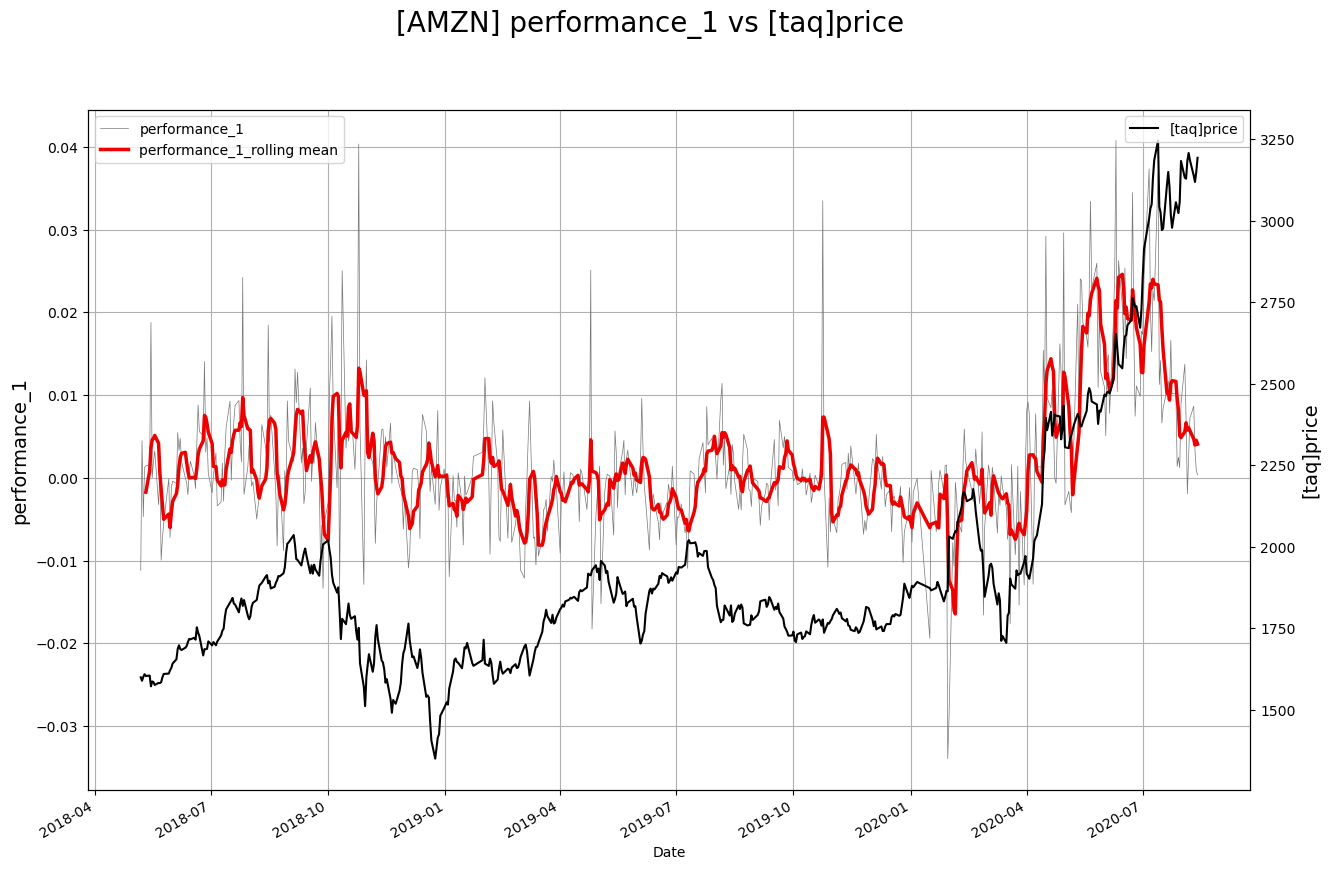

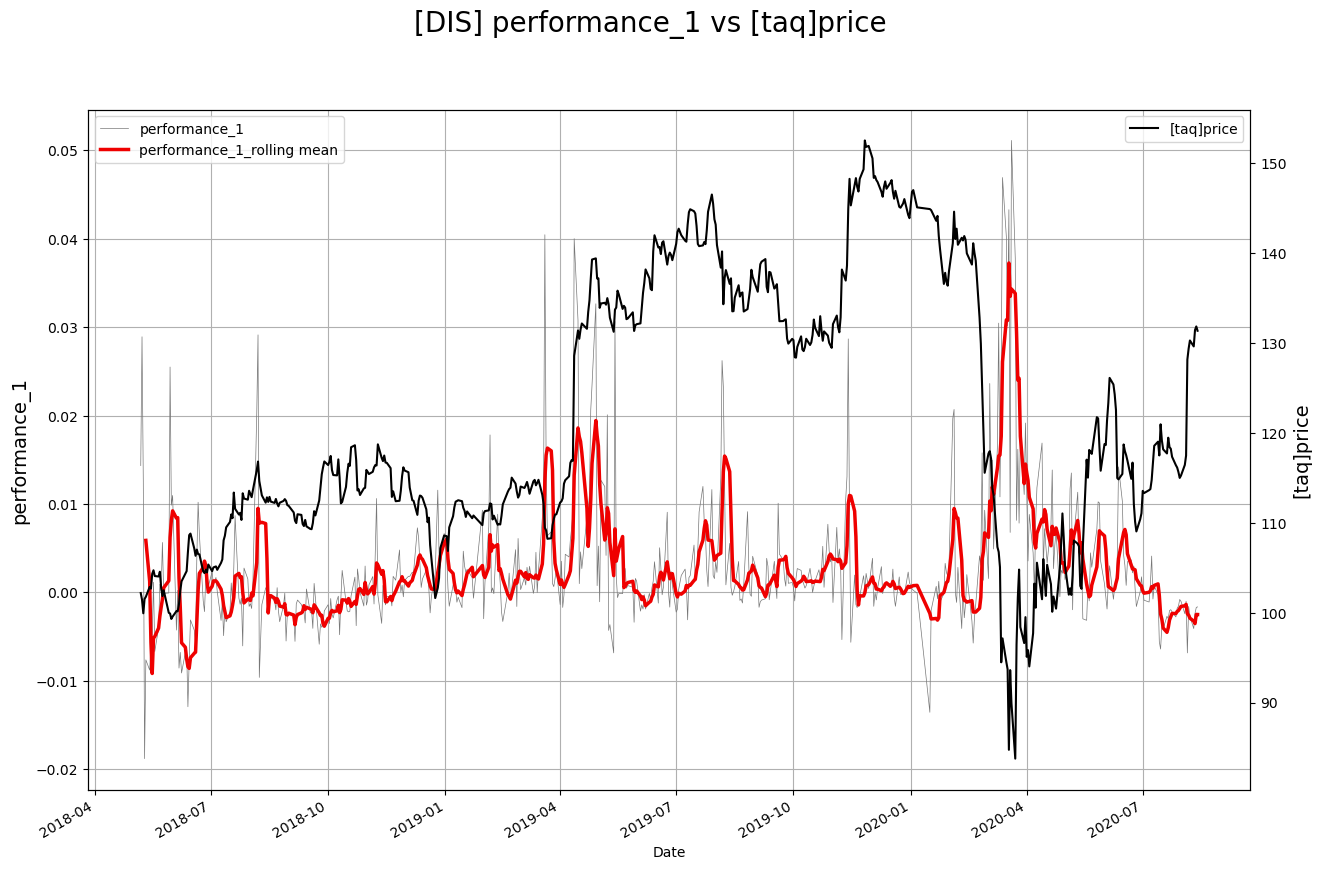

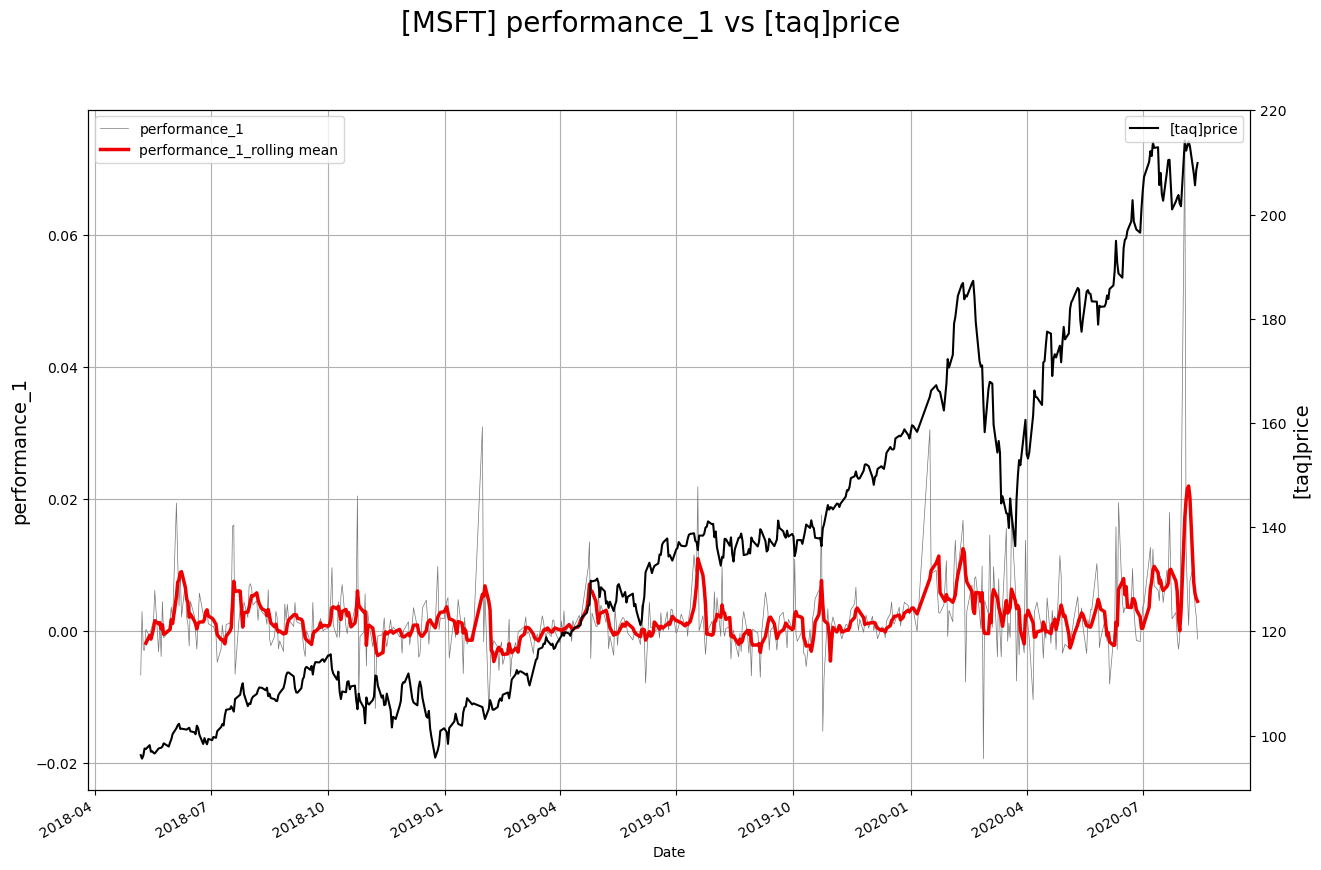

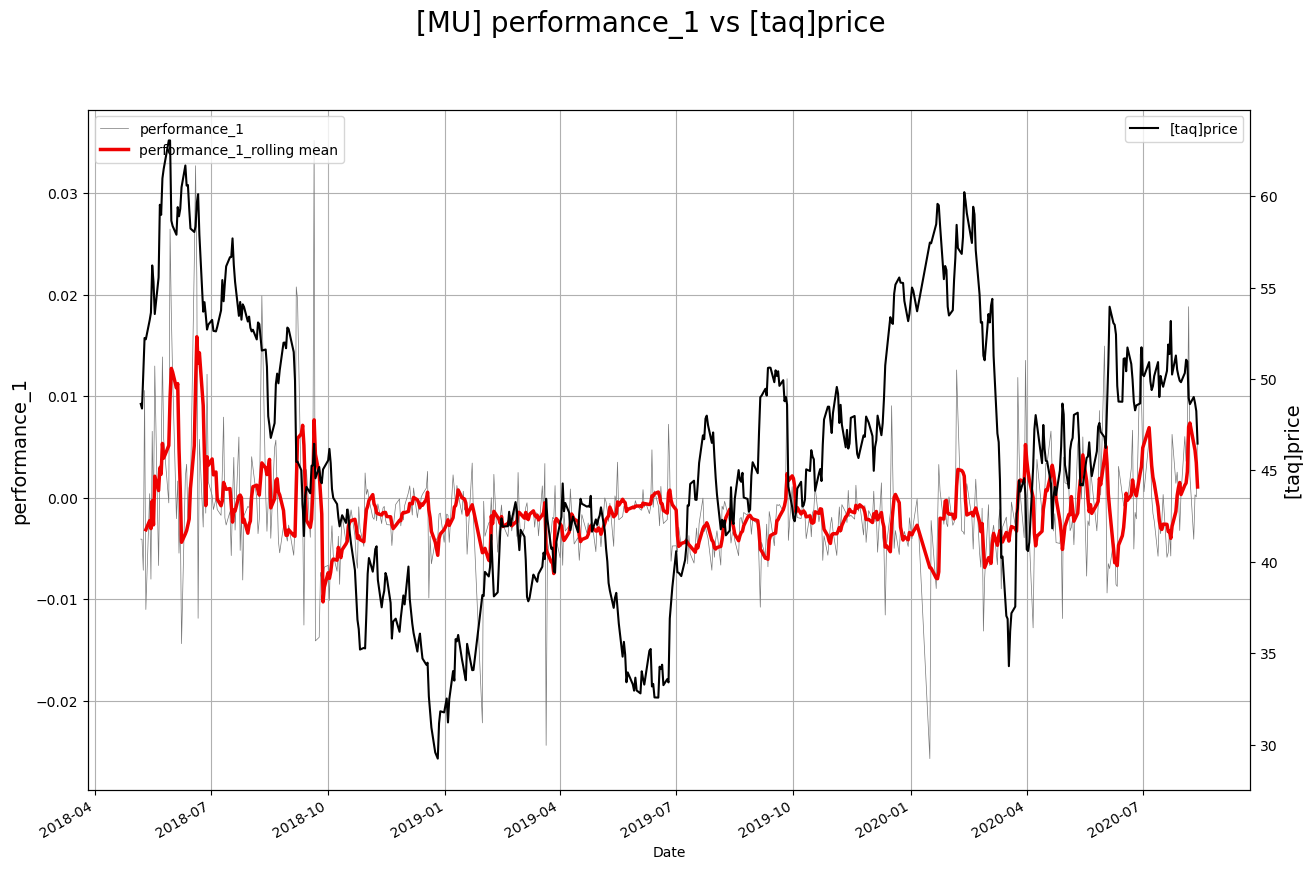

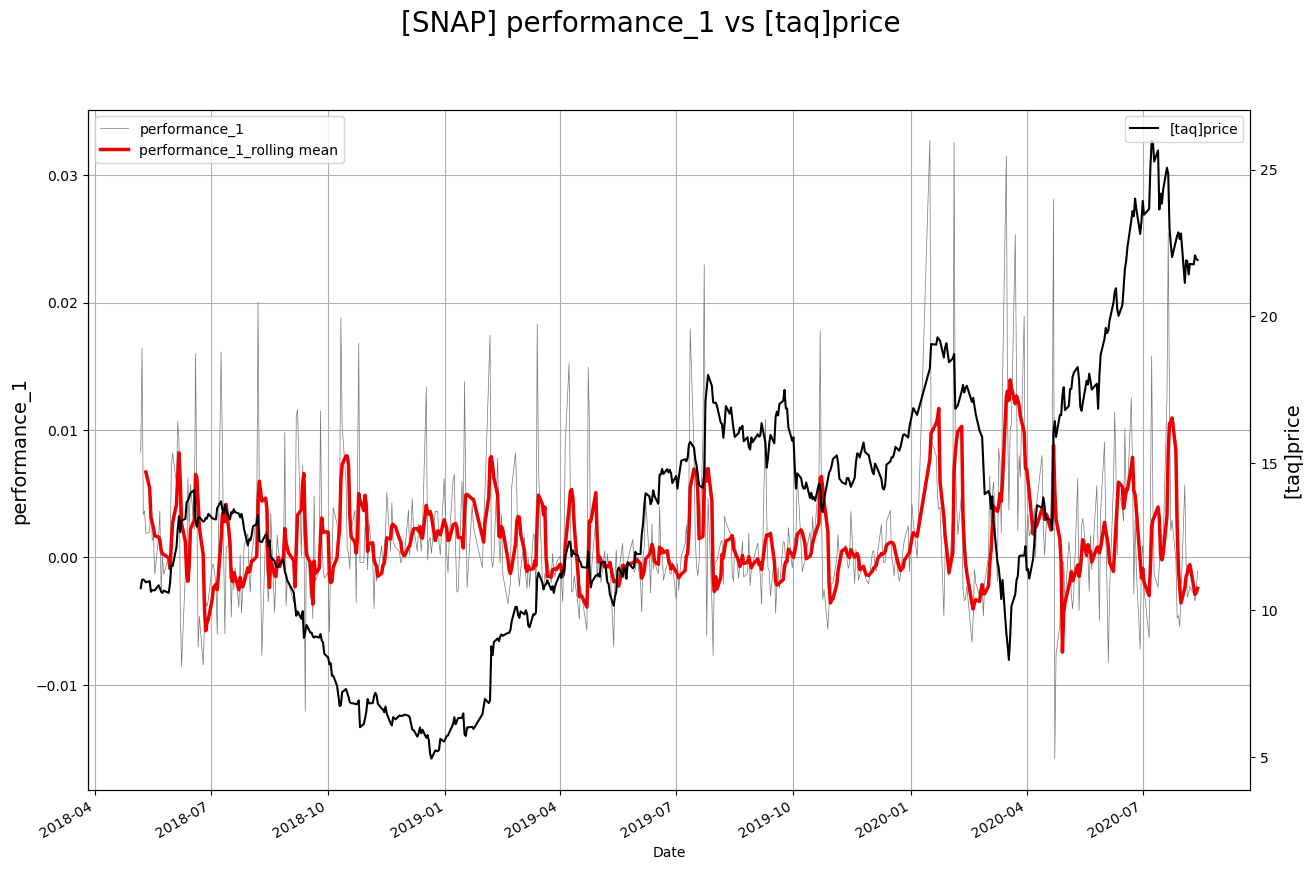

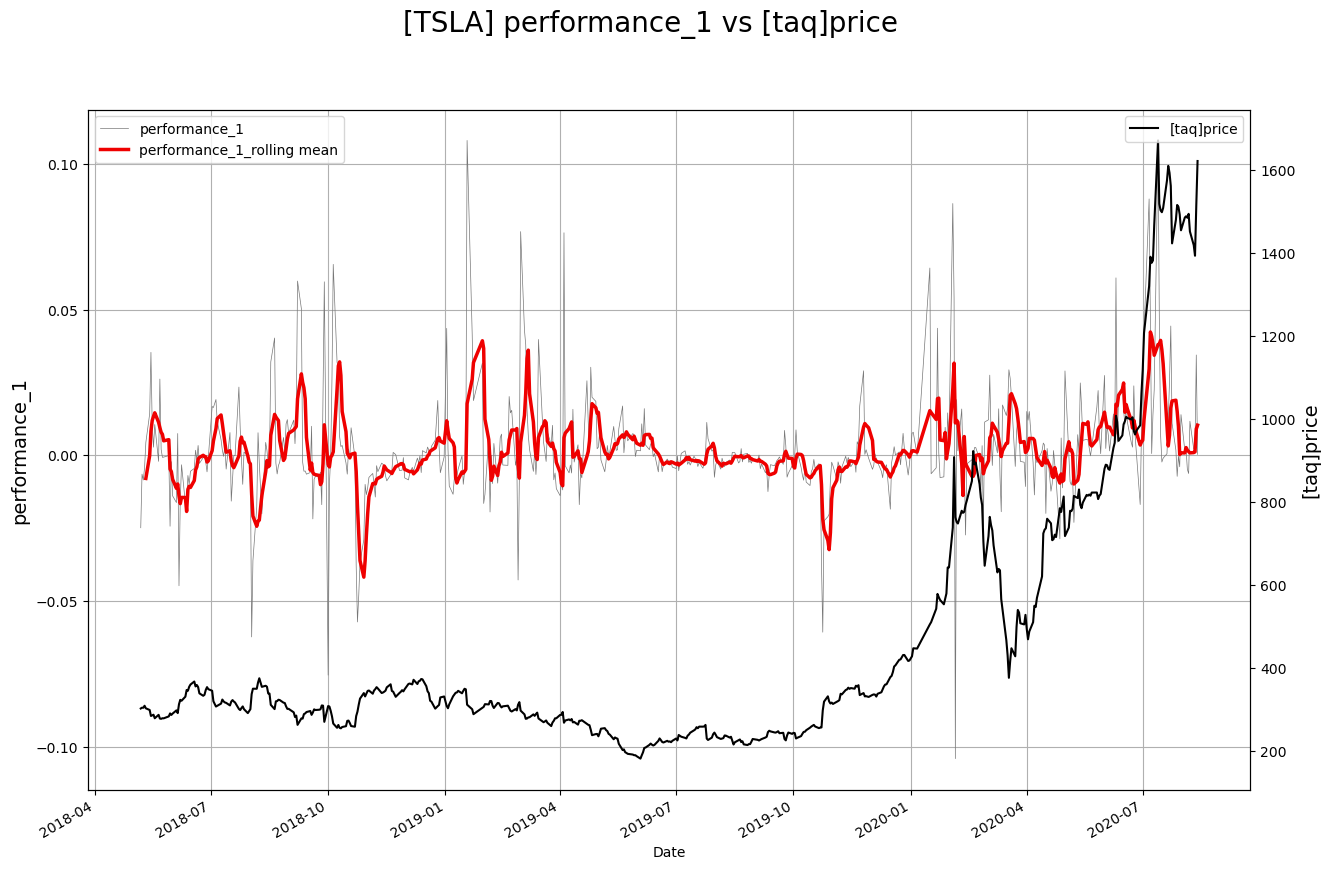

In [204]:
# ticker_list = ['TLRY','TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'LULU', 'BAC', 'GME']
# !!! TLRY

ticker_list = ['TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AMZN']
# ticker_list = ['AMZN']
plot_ticker(ticker_list, x='date', y1='performance_1', y2='[taq]price')

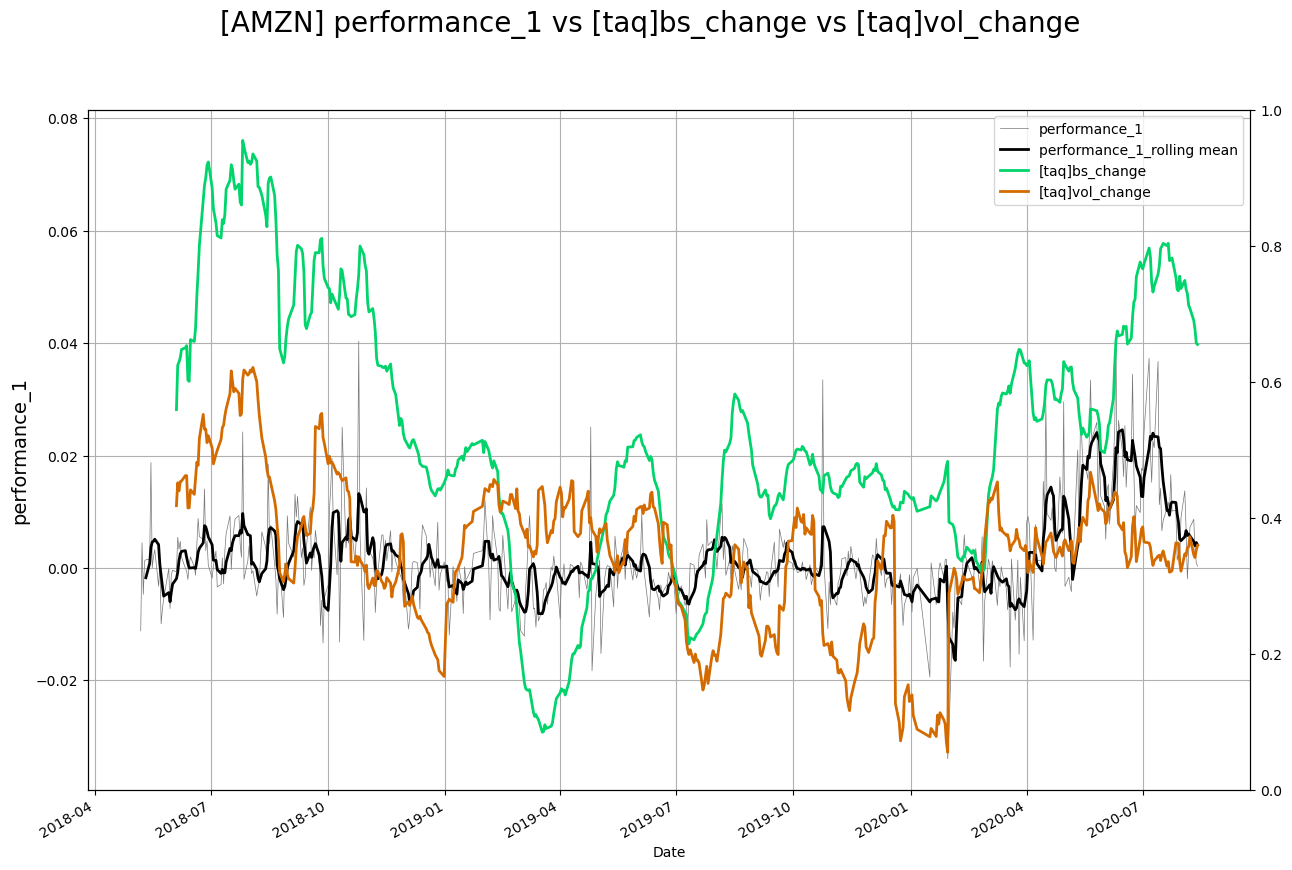

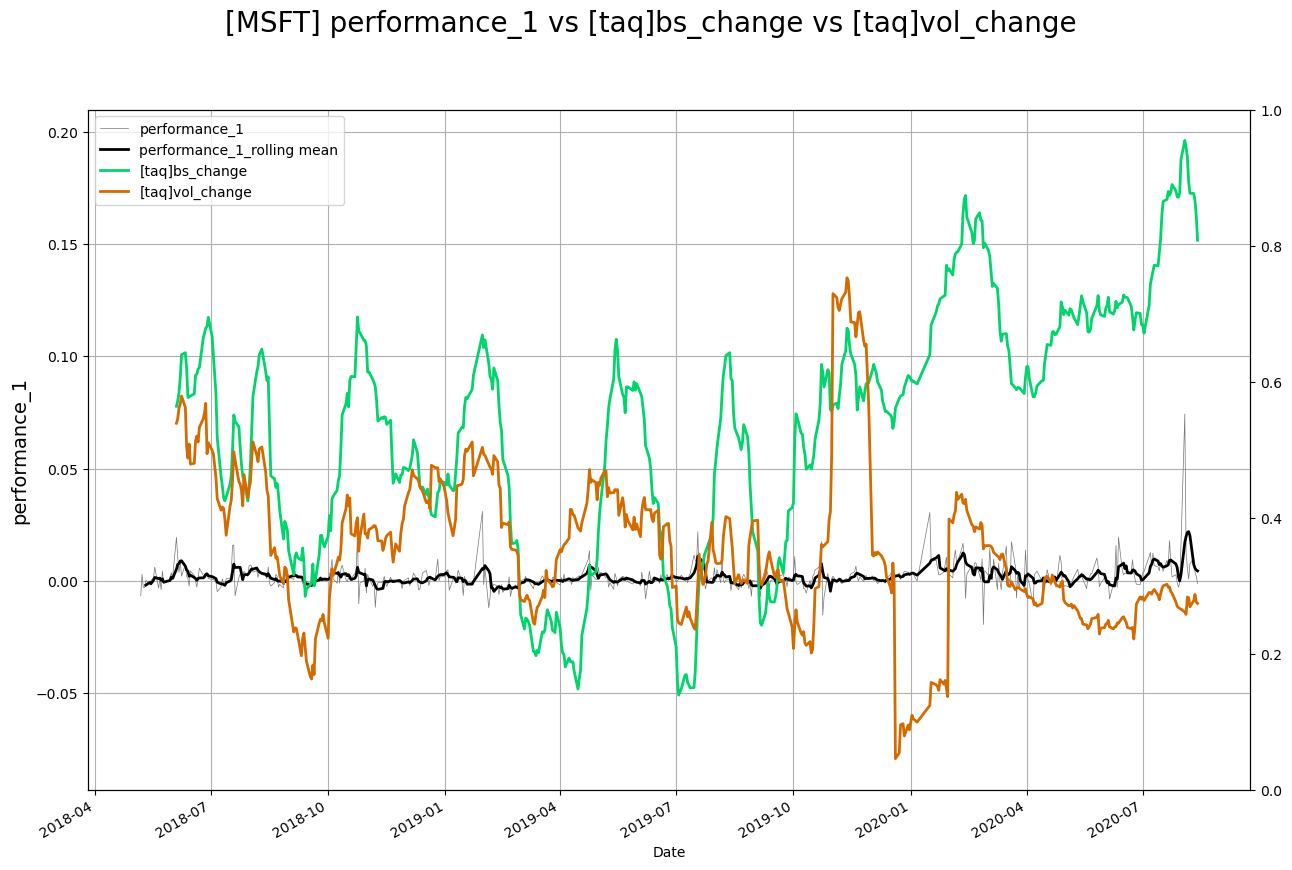

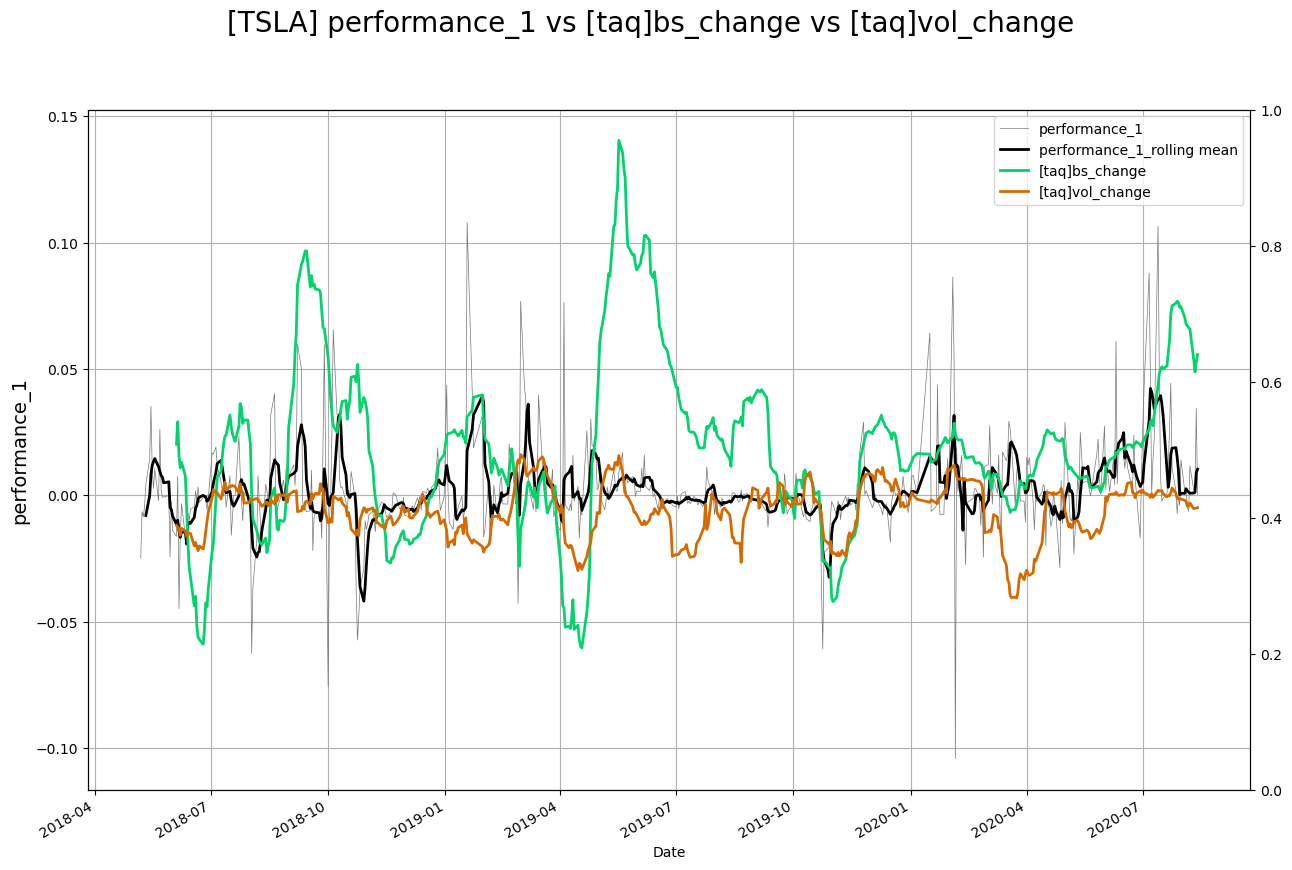

In [186]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]bs_change', y3='[taq]vol_change'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_0 = "#777777"
    colour_1 = "#000000"
    colour_2 = "#00D46B"
    colour_3 = "#d46b00"

    
    ax1.plot(df[x], df[y1], label=f"{y1}", color=colour_0, lw=0.5) 
    ax1.plot(df[x], df[y1].rolling(5).mean(), label=f"{y1}_rolling mean", color=colour_1, lw=2, alpha=1)
    ax1.plot(df[x], df[y2].rolling(20).mean(), label=y2, color=colour_2, lw=2, alpha=1)
    ax1.plot(df[x], df[y3].rolling(20).mean(), label=y3, color=colour_3, lw=2, alpha=1)

    # This line is a rolling average, useful for getting a better view of the data
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()
    ax1.legend()
    
    fig.suptitle(f"[{ticker}] {y1} vs {y2} vs {y3}", fontsize=20)
    fig.autofmt_xdate()

ticker_list = ['TSLA', 'MSFT', 'AMZN']

plot_ticker(ticker_list, x='date', y1='performance_1', y2='[taq]bs_change')

## Todo <a class="anchor" id="bullet6"></a>

 [Go back up](#top)

In [ ]:
cols = list(acc_holdings_df.columns)
print(cols)



In [33]:
#     ------------ Create df['RHtotal_holdings_change'] column     ------------



,date,RHtotal_holdings,RHtotal_holdings_change,user_estimate,AUSpU
0,2018-05-03,143747,NaN,2373846.0,0.060554
1,2018-05-04,141424,-2323.0,2379231.0,0.059441
2,2018-05-07,141179,-245.0,2384615.0,0.059204
3,2018-05-08,140820,-359.0,2390000.0,0.058921
4,2018-05-09,140742,-78.0,2395385.0,0.058755


Loop all files and perform above operations for tickers.

In [7]:
"""
# Check how % ownership of firm changes compared to RH platform

# Add and smooth for missing days (it seens Robintrack had outages)
- 8-10 aug 2018
- 23-30 january 2019
- 6-16 january 2020

# Make final prediction method
                                        Prediction 1: 
stock_holdings t1 = stock_holdings t0 + (% user bezit * verandering totaal stock ownership RH)
                                        Prediction 2: 
stock_holdings t1 = stock_holdings t0 + (% user bezit * (verandering totaal stock ownership RH / avg_stocks_user))


# ... Reddit
"""


In [ ]:
    #         ax = df.plot(x="date", y=["performance_1", "performance_2"], lw=2, alpha=1, colormap='jet', markersize=10, title='Average unique shares per user (AUSpU)')
    #         ax.set(xlabel="date", ylabel="AUSpU")
    #         plt.show()


In [92]:
ticker_list = ['TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'TLRY', 'LULU', 'BAC', 'GME']

relative_size_df = total_users
for ticker in ticker_list:
    # Get ticker information from combined dataframe
    ticker_df = df[df['ticker'] == ticker].reset_index()
    
    # Only keep 2 necessary columns
    ticker_df = ticker_df[['date', 'users_holding']]
    
    # Rename column users_holding to ticker name
    ticker_df.rename(columns={'users_holding': f'{ticker}'}, inplace=True)
    
    # Merge with total users holding data
    relative_size_df = relative_size_df.merge(ticker_df, how='outer', left_on='date', right_on='date')


In [29]:
ticker_list = ['TSLA', 'MU', 'SNAP', 'AMD', 'DIS', 'MSFT', 'AAPL', 'AMZN', 'SQ', 'BABA', 'V', 'NFLX', 'IQ', 'ATVI', 'SHOP', 'BA', 'NVDA', 'GE', 'WMT', 'SBUX', 'F', 'TLRY', 'LULU', 'BAC', 'GME']


In [ ]:
relative_size_df

In [74]:
total_users = df[['date', 'users_holding']].groupby('date', as_index=False).sum()
total_users.to_csv(r'E:\Users\Christiaan\Large_Files\Thesis\robintrack\all_stocks.csv', encoding='utf-8')
